# Initial Set-Up

In [12]:
import pickle
import pandas as pd
import matplotlib
import os
import re

import collections
import datetime
import time

import geopandas as gpd

import numpy as np

import rasterio

In [2]:
file = "data/infogroup.csv"
hq = pd.read_csv(file, encoding = 'unicode_escape')[['TICKER','archive_version_year',
                                                    'company','city','state','zipcode',
                                                    'latitude','longitude','business_status_code']]
hq = hq[hq.business_status_code == 1.0]

/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Convert into geospatial dataframe.

In [3]:
geoHQ = gpd.GeoDataFrame(
    hq,
    geometry=gpd.points_from_xy(
        hq["longitude"],
        hq["latitude"],
    ),
    crs={"init":"EPSG:4326"},
)

/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [4]:
geoHQ[geoHQ.archive_version_year == 1997].plot()

This is the most basic version of the HQ information. BS takes it a step further by filtering for firms where the HQ are responsible for at least a certain percentage of the overall sales.

In [5]:
file = "data/infogroup.csv"
hqSales = pd.read_csv(file, encoding = 'unicode_escape')
hqSales = hqSales[hqSales.business_status_code == 1.0]

/Users/brianreed/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Overstate the size of a location relative to the parent: put parent at low end and location at high end of ranges.

In [6]:
hqSales.loc[hqSales.parent_employee_size_code == 'A', 'parent_employee_size_code'] = 1
hqSales.loc[hqSales.parent_employee_size_code == 'B', 'parent_employee_size_code'] = 5
hqSales.loc[hqSales.parent_employee_size_code == 'C', 'parent_employee_size_code'] = 10
hqSales.loc[hqSales.parent_employee_size_code == 'D', 'parent_employee_size_code'] = 20
hqSales.loc[hqSales.parent_employee_size_code == 'E', 'parent_employee_size_code'] = 50
hqSales.loc[hqSales.parent_employee_size_code == 'F', 'parent_employee_size_code'] = 100
hqSales.loc[hqSales.parent_employee_size_code == 'G', 'parent_employee_size_code'] = 250
hqSales.loc[hqSales.parent_employee_size_code == 'H', 'parent_employee_size_code'] = 500
hqSales.loc[hqSales.parent_employee_size_code == 'I', 'parent_employee_size_code'] = 1000
hqSales.loc[hqSales.parent_employee_size_code == 'J', 'parent_employee_size_code'] = 5000
hqSales.loc[hqSales.parent_employee_size_code == 'K', 'parent_employee_size_code'] = 10000


In [7]:
hqSales.loc[hqSales.location_employee_size_code == 'A', 'location_employee_size_code'] = 4
hqSales.loc[hqSales.location_employee_size_code == 'B', 'location_employee_size_code'] = 9
hqSales.loc[hqSales.location_employee_size_code == 'C', 'location_employee_size_code'] = 19
hqSales.loc[hqSales.location_employee_size_code == 'D', 'location_employee_size_code'] = 49
hqSales.loc[hqSales.location_employee_size_code == 'E', 'location_employee_size_code'] = 99
hqSales.loc[hqSales.location_employee_size_code == 'F', 'location_employee_size_code'] = 249
hqSales.loc[hqSales.location_employee_size_code == 'G', 'location_employee_size_code'] = 499
hqSales.loc[hqSales.location_employee_size_code == 'H', 'location_employee_size_code'] = 999
hqSales.loc[hqSales.location_employee_size_code == 'I', 'location_employee_size_code'] = 4999
hqSales.loc[hqSales.location_employee_size_code == 'J', 'location_employee_size_code'] = 9999
hqSales.loc[hqSales.location_employee_size_code == 'K', 'location_employee_size_code'] = 10000


In [8]:
hqSales['location_employee_size_code'] = pd.to_numeric(hqSales['location_employee_size_code'], errors='coerce')
hqSales['parent_employee_size_code'] = pd.to_numeric(hqSales['parent_employee_size_code'], errors='coerce')
hqSales['employeesAtLocation'] = hqSales['location_employee_size_code']/hqSales['parent_employee_size_code']

In [9]:
hqSales['employeesAtLocation'].describe()

count    25062.000000
mean         2.309869
std          3.454106
min          0.000800
25%          1.980000
50%          1.998000
75%          2.490000
max        249.000000
Name: employeesAtLocation, dtype: float64

In [10]:
sum(hqSales.employeesAtLocation > 0.75)/hqSales.shape[0]

0.7723205206426683

Filter down the location information to firms where we have at least 75% of employees at HQ.

In [11]:
geoHQ = geoHQ[hqSales.employeesAtLocation > 0.75].reset_index()

In [18]:
geoHQ.drop(columns = ['index','geometry']).to_csv('data/geoHQ.csv')

# Weather Data
## *this is deprecated now - see prismdata file

Start with the BEST data.

The temperature data here is the temperature anomaly - difference in degrees celsius from average. Climatology has the estimate of the true surface temperature for each day of year from 1951 - 1980.

In [14]:
tmax = rasterio.open('data/PRISM_tmax_stable_4kmD2_20100101_20101231_bil/PRISM_tmax_stable_4kmD2_20101231_bil.bil')

In [16]:
tmax

<open DatasetReader name='data/PRISM_tmax_stable_4kmD2_20100101_20101231_bil/PRISM_tmax_stable_4kmD2_20101231_bil.bil' mode='r'>

In [19]:
import netCDF4 as nc
import xarray as xr

In [20]:
file = 'data/Complete_TMAX_Daily_LatLong1_2010.nc'
temps = xr.open_dataset(file)   #  nc.Dataset(file)

In [21]:
geoHQ.head()

,index,TICKER,archive_version_year,company,city,state,zipcode,latitude,longitude,business_status_code,geometry
0,983,SODI,1998,SOLITRON DEVICES INC,WEST PALM BEACH,FL,33407,26.74120,-80.06694,1.0,POINT (-80.06694 26.74120)
1,988,SLGD,1998,SCOTT'S LIQUID GOLD INC,DENVER,CO,80239,39.78393,-104.83663,1.0,POINT (-104.83663 39.78393)
2,989,TWIN,1998,TWIN DISC INC,RACINE,WI,53403,42.71621,-87.79466,1.0,POINT (-87.79466 42.71621)
3,991,INTC,1998,INTEL CORP,SANTA CLARA,CA,95052,37.34933,-121.94723,1.0,POINT (-121.94723 37.34933)
4,998,HTCH,1998,HUTCHINSON TECHNOLOGY INC,HUTCHINSON,MN,55350,44.89850,-94.35487,1.0,POINT (-94.35487 44.89850)


In [22]:
testHQ = geoHQ.iloc[1,:]

In [54]:
testHQ

TICKER                                                  SIF
archive_version_year                                   1997
company                                SIFCO INDUSTRIES INC
city                                              CLEVELAND
state                                                    OH
zipcode                                               44103
latitude                                           41.52586
longitude                                          -81.6471
business_status_code                                    1.0
geometry                POINT (-81.64709999999999 41.52586)
Name: 1, dtype: object

In [55]:
# Extract a dataset closest to specified point
test = temps.sel(testHQ[['latitude','longitude']], method='nearest')

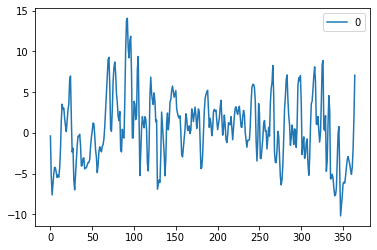

In [56]:
pd.DataFrame(test.temperature[test.year == 2010]).plot()

Now go through and make this iterable for the entire list.

In [51]:
i = 0
# geoHQ.loc[i,['latitude','longitude']]

temps.sel(hqPost2010.loc[i,['latitude','longitude']], method='nearest')


KeyError: 0

In [52]:
hqPost2010 = geoHQ[geoHQ.archive_version_year > 2010].reset_index()

In [58]:
start = time.time()



tempsList = list()
for i in range(0,hqPost2010.shape[0]):
    nearbyTemps = temps.sel(hqPost2010.loc[i,['latitude','longitude']], method='nearest')
    
    tempsList.append(list(np.array(nearbyTemps.temperature[nearbyTemps.year == hqPost2010.archive_version_year[i]])))

    if (i%100 == 0):
        print(i)
    
print(time.time() - start)






0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200


IndexError: The indexing operation you are attempting to perform is not valid on netCDF4.Variable object. Try loading your data into memory first by calling .load().

In [60]:
outfile =  'data/hqDailyTemperatures.pkl'
with open(outfile, 'wb') as pickle_file:
    pickle.dump(tempsList, pickle_file)